In [1]:
import torch
from ConditionalMNIST import load_mnist, get_observation_pixels
import numpy as np
import matplotlib.pyplot as plt

BATCH_SIZE = 128
train_loader, test_loader, val_loader = load_mnist(BATCH_SIZE)

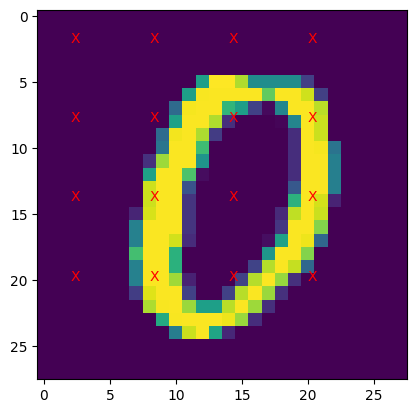

In [2]:
from plotting import plot_sample_with_conditioned_pixels
example = next(iter(test_loader))[0][0][0].numpy()
plot_sample_with_conditioned_pixels(example)

In [3]:
import pytorch_lightning as pl
from SCVAE import ConditionalVAE

class SCVAE(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.ConditionalVAE = ConditionalVAE()
    
    def forward(self, x, x_cond):
        return self.ConditionalVAE(x, x_cond)
    
    def training_step(self, batch, batch_idx):
        x, x_cond, y = batch
        output, z_mean, z_log_var, z = self.ConditionalVAE(x, x_cond)
        recon_loss, kl_loss, loss = self.ConditionalVAE.loss(x, output, z_mean, z_log_var)
        self.log('train_loss', loss)
        self.log('train_recon_loss', recon_loss)
        self.log('train_kl_loss', kl_loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, x_cond, y = batch
        output, z_mean, z_log_var, z = self.ConditionalVAE(x, x_cond)
        recon_loss, kl_loss, loss = self.ConditionalVAE.loss(x, output, z_mean, z_log_var)
        self.log('val_loss', loss)
        self.log('val_recon_loss', recon_loss)
        self.log('val_kl_loss', kl_loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, x_cond, y = batch
        output, z_mean, z_log_var, z = self.ConditionalVAE(x, x_cond)
        recon_loss, kl_loss, loss = self.ConditionalVAE.loss(x, output, z_mean, z_log_var)
        self.log('test_loss', loss)
        self.log('test_recon_loss', recon_loss)
        self.log('test_kl_loss', kl_loss)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)
    

In [5]:
from pytorch_lightning.callbacks import RichProgressBar
scvae = SCVAE.load_from_checkpoint('scvae.ckpt')
trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=50, enable_progress_bar=True, callbacks=[RichProgressBar()])
trainer.fit(scvae, train_loader, val_loader)
#save
trainer.save_checkpoint('scvae2.ckpt')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/edvardsz/Desktop/Masters/MastersThesis/tutorials/semi-conditional-variational-autoencoder/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name           ┃ Type           ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ ConditionalVAE │ ConditionalVAE │ 10.7 M │
└───┴────────────────┴────────────────┴────────┘

Trainable params: 10.7 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 10.7 M                                                                                               
Total estimated model params size (MB): 42

Output()

`Trainer.fit` stopped: `max_epochs=50` reached.


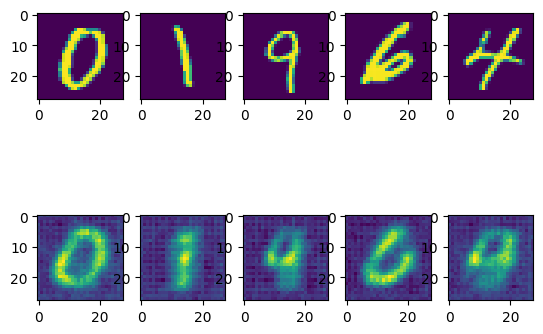

In [4]:
#load
scvae = SCVAE.load_from_checkpoint('scvae2.ckpt')
scvae.eval()
from plotting import plot_samples_with_reconstruction
# plot some samples and their reconstruction
plot_samples_with_reconstruction(scvae, next(iter(test_loader)))